# ***Living Earth*** Validation of thematic maps <img align="right" src="../../Supplementary_data/dea_logo.jpg">

* [**Sign up to the DEA Sandbox**](https://docs.dea.ga.gov.au/setup/sandbox.html) to run this notebook interactively from a browser
* **Compatibility:** Notebook currently compatible with the `DEA Sandbox` environment


## Generating ground reference points
The Earthtrack mobile application allows recording of land cover, habitats and land cover change on the ground.  
For land cover, Earthtrack replicates all categories of the [Food and Agriculture Organisation (FAO) Land Cover Classification System (LCCS)](https://www.fao.org/4/y7220e/y7220e00.htm).  This includes the understorey strata for which a specific module is included.  

For land cover change, both impact and pressure categories are recorded according to the Global Change Taxonomy of [Lucas *et al.* (2022)](https://onlinelibrary.wiley.com/doi/full/10.1111/gcb.16346), which relates to the Evidence-Based Change Framework of *Living Earth*.

Habitat recording is currently only available for Wales where the [Phase 1 Habitat Classification of the Joint Nature Conservation Committee (JNCC)](https://data.jncc.gov.uk/data/9578d07b-e018-4c66-9c1b-47110f14df2a/Handbook-Phase1-HabitatSurvey-Revised-2016.pdf) is used as the base taxonomy, although there is capacity to record land cover information within this module. 

All points recorded by Earthtrack are available as and when submitted on either directly from the [Earthtrack portal](https://earthtrack.aber.ac.uk/lccs/world.html) or the [Living Earth website](https://livingearthhub.org/) and specifically from [Earthtrack tools](https://livingearthhub.org/tools/earthtrack-app-information/).


## Study Areas: The Lower Daintree River, north Queensland, Australia
The [Daintree River](https://en.wikipedia.org/wiki/Daintree_River) is located in Far North Queensland (QLD) and is a biodiverse region associated with tropical rainforests, mangroves, undammned rivers and natural exposures of bare surfaces.  Sugar cane is the main crop cultivated in the region and the main settlement is Daintree.  The area is part of the [World Heritage Wet Tropics Region](https://whc.unesco.org/en/list/486/#:~:text=The%20Wet%20Tropics%20of%20Queensland,its%20rich%20and%20unique%20biodiversity.).  

In 2023/24, [Cyclone Jasper](https://en.wikipedia.org/wiki/Cyclone_Jasper) made landfall and caused significant flooding to the coastal region, despite the wind strength being relatively low.

## Description 
This notebook accesses the FAO LCCS layer at Level 3 (Basic; 6 classes) but also Level 4 (over 100 classes) to gather evidence for impacts and associates these with aligned pressure categories. This is achieved by:

1. Extracts land cover maps from Digital Earth Australia (DEA) for a specific year and allows viewing of the Overarching Environmental Descriptors (OEDs; Level 3) and Essential Environmental Descriptors (EEDs), namely lifeform, vegetation cover, water state and water persistence.  
2. Loads a .csv file of land cover records (OEDs, Level 3) a) extracted from *Living Earth's* Earthtrack Geoportal and b) generated through visual interpretation of land cover from very high resolution imagery (Google Earth).
3. Constructs an confusion matrix showing the correspondence between the mapped OEDs and those assigned to points through either Earthtrack or visual interpretation of VHR imagery.
4. Calculates the standard metrics (%) of Users and Producers Accuracy and Overall Accuracy.
5. Exports the confusion matrix to a .csv file for further calculations and/or formatting.

This notebook requires a basic understanding of the DEA Land Cover data set.  For more information, visit [DEA Land Cover notebook](../DEA_datasets/DEA_Land_Cover.ipynb) first. 

***

## Install relevant tools and libraries

In [1]:
from Tools_and_libraries import *
# Ensure openpyxl is installed
!pip install openpyxl

added a new line here
another line


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/richard.lucas@aber.ac.uk/proxy/39245/status,
Dashboard: /user/richard.lucas@aber.ac.uk/proxy/39245/status,Workers: 1
Total threads: 2,Total memory: 12.21 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:33969,Workers: 1
Dashboard: /user/richard.lucas@aber.ac.uk/proxy/39245/status,Total threads: 2
Started: Just now,Total memory: 12.21 GiB
Comm: tcp://127.0.0.1:41469,Total threads: 2
Dashboard: /user/richard.lucas@aber.ac.uk/proxy/37015/status,Memory: 12.21 GiB
Nanny: tcp://127.0.0.1:42285,


## Load and plot ground validation datasets
In the following cell, you have the option to select the following:

a)  Earthtrack records of land cover and associated environmental descriptors collected from the Daintree River in 2024.

b)  Point data interpreted from VHR satellite imagery (Daintree_interpreted.csv).  Note that these were generated through [geojson.io](https://geojson.io) and by selecting the point collection tool and saving as a shapefile.  Each point has to be given a number (e.g., 111 or 124 representing Cultivated Terrestrial Vegetation and Natural Aquatic Vegetation respectively (see below).   A style file for use with QGIS is also provided.

Select one of these files below (e.g., after "data = pd.read_csv ..." by commenting or uncommenting the line - use CNTRL ? or CMD ?). 
Note you can repeat the cells following using either the Earthtrack or visually interpreted data.

View the distribution of points as standalone but you will also be able to overlay on top of the land cover data later in the laboratory.


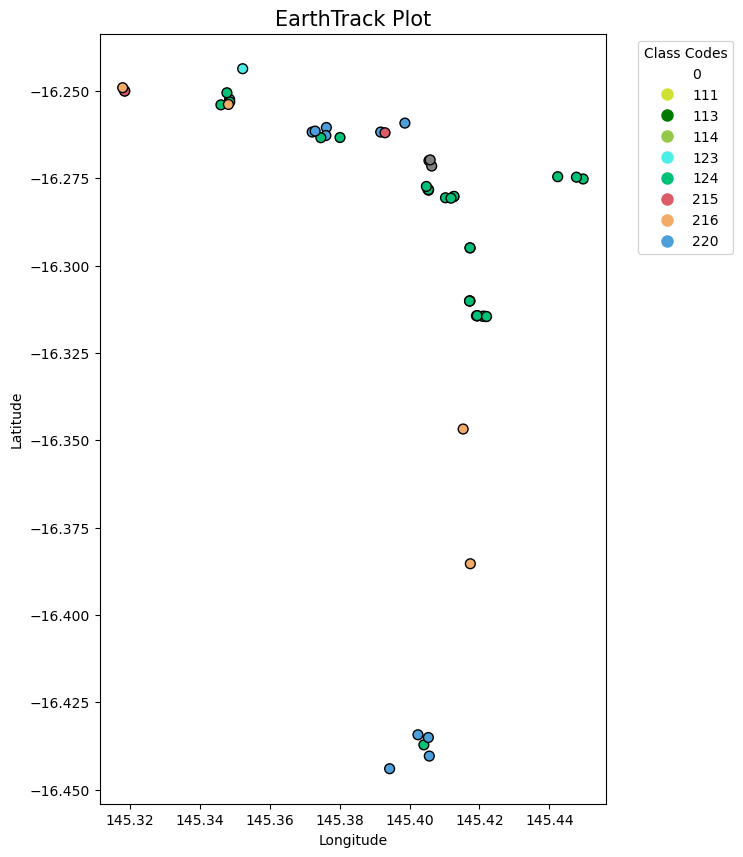

Longitude range: (145.317879058556, 145.449674467063)
Latitude range: (-16.4439874, -16.2436372583768)


In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
from matplotlib.lines import Line2D
from mycolourschemes import l3change_colors, l3change_labels

data = pd.read_csv('./er/Daintree_earthtrack.csv')
#data = pd.read_csv('./er/Daintree_interpreted.csv')

data['l3classifcode'] = data['l3classifcode'].str.strip()
data['l3classifcode'] = data['l3classifcode'].astype(str)

data = data[data['l3classifcode'] != 'nan']

geometry = [Point(xy) for xy in zip(data['X'], data['Y'])]
geo_data = gpd.GeoDataFrame(data, geometry=geometry)

class_code_map = {
    'NAV': 124.0,
    'W': 220.0,
    'BS': 216.0,
    'AS': 215.0,
    'NTV': 112.0,
    'CAV': 123.0,
    'CTV': 111.0,
    
}

data['class_code'] = data['l3classifcode'].map(class_code_map)


class_code_to_color = {value[0]: key for key, value in l3change_colors.items()}

data['color'] = data['class_code'].map(lambda x: class_code_to_color.get(x, "#808080"))


geo_data = gpd.GeoDataFrame(data, geometry=geometry)

fig, ax = plt.subplots(figsize=(10, 10))

scatter = geo_data.plot(ax=ax, color=geo_data['color'], edgecolor='black', markersize=50)

ax.set_title('EarthTrack Plot', fontsize=15)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

legend_handles = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=str(int(code)))
    for color, (code, label) in l3change_colors.items()
]

ax.legend(handles=legend_handles, title="Class Codes", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

lon_range = (data['X'].min(), data['X'].max())
lat_range = (data['Y'].min(), data['Y'].max())

print(f"Longitude range: {lon_range}")
print(f"Latitude range: {lat_range}")


### View the land cover maps
Load the shapefile "DaintreeExtent.shp" so you can view the land cover maps.   

In [3]:
from ipyleaflet import Map, DrawControl, Rectangle, WidgetControl, LayersControl, FullScreenControl, GeoJSON, basemaps
from ipywidgets import Button, VBox, Tab, FloatText, Output, Layout, HBox, HTML, Dropdown
from shapely.geometry import Polygon
import gc
import geopandas as gpd
from ipyfilechooser import FileChooser
import json

# Initialize global variables to store the selected polygon
selected_polygon = None
manual_polygon_layer = None
geojson_layer = None

# Define lat_range and lon_range to avoid NameError in Section 5
lat_range = None
lon_range = None

# Create the map
m = Map(center=[0, 0], zoom=2, basemap=basemaps.Esri.WorldImagery, scroll_wheel_zoom=True, layout=Layout(height='600px'))
m.add_control(LayersControl(position='topright'))
m.add_control(FullScreenControl())

# Output widgets to display coordinates
output_draw = Output(layout={'border': '1px solid black', 'padding': '5px'})
output_manual = Output(layout={'border': '1px solid black', 'padding': '5px'})
output_load = Output(layout={'border': '1px solid black', 'padding': '5px'})

### Draw Method ###
# Setup the draw control with both polygon and rectangle options
draw_control = DrawControl(
    rectangle={"shapeOptions": {"color": "#0000FF"}},
    polygon={"shapeOptions": {"color": "#00FF00"}},
    circlemarker={},
    polyline={},
    circle={}
)
m.add_control(draw_control)

# Event handler for drawing shapes
def handle_draw(target, action, geo_json):
    global selected_polygon, lat_range, lon_range
    output_draw.clear_output()
    coords = geo_json['geometry']['coordinates'][0]
    selected_polygon = Polygon(coords)
    lats, lons = zip(*[(coord[1], coord[0]) for coord in coords])
    lat_range = (min(lats), max(lats))
    lon_range = (min(lons), max(lons))
    with output_draw:
        output_draw.append_stdout("Coordinates:\n")
        output_draw.append_stdout(f"{'Latitude':<20}{'Longitude'}\n")
        for lat, lon in zip(lats, lons):
            output_draw.append_stdout(f"{lat:.6f}\t\t{lon:.6f}\n")

draw_control.on_draw(handle_draw)

# Button to clear drawings and output
clear_button_draw = Button(description='Clear All')

# Event handler for the clear button
def clear_all_draw(b):
    global selected_polygon, lat_range, lon_range
    draw_control.clear()
    output_draw.clear_output()
    selected_polygon = None
    lat_range = None
    lon_range = None
    gc.collect()

clear_button_draw.on_click(clear_all_draw)

draw_tab = VBox([clear_button_draw, output_draw])

### Manual Input Method ###
# Create input widgets for manual coordinate entry
latitude = FloatText(description='Latitude:', layout=Layout(width='100%'))
longitude = FloatText(description='Longitude:', layout=Layout(width='100%'))
buffer = FloatText(description='Buffer (deg):', value=0.1, layout=Layout(width='100%'))
update_button = Button(description='Update Map')

# Function to update the map based on manual input values
def update_map_manual(b):
    global manual_polygon_layer, selected_polygon, lat_range, lon_range
    output_manual.clear_output()
    lat = latitude.value
    lon = longitude.value
    buf = buffer.value
    
    if lat is not None and lon is not None and buf is not None:
        bounds = [[lat - buf, lon - buf], [lat + buf, lon + buf]]
        if manual_polygon_layer:
            m.remove_layer(manual_polygon_layer)
        manual_polygon_layer = Rectangle(bounds=bounds, color="blue", fill_opacity=0.2, weight=2)
        m.add_layer(manual_polygon_layer)
        m.fit_bounds(bounds)
        
        selected_polygon = Polygon([(lon - buf, lat - buf), (lon + buf, lat - buf), (lon + buf, lat + buf), (lon - buf, lat + buf), (lon - buf, lat - buf)])
        lat_range = (lat - buf, lat + buf)
        lon_range = (lon - buf, lon + buf)
        
        with output_manual:
            output_manual.append_stdout("Manual Coordinates:\n")
            output_manual.append_stdout(f"{'Latitude':<20}{'Longitude'}\n")
            output_manual.append_stdout(f"{lat - buf:.6f}\t\t{lon - buf:.6f}\n")
            output_manual.append_stdout(f"{lat - buf:.6f}\t\t{lon + buf:.6f}\n")
            output_manual.append_stdout(f"{lat + buf:.6f}\t\t{lon + buf:.6f}\n")
            output_manual.append_stdout(f"{lat + buf:.6f}\t\t{lon - buf:.6f}\n")
    else:
        with output_manual:
            output_manual.append_stdout("Please fill in all coordinate values.\n")

# Connect the manual update button
update_button.on_click(update_map_manual)

# Button to clear manual input and output
clear_button_manual = Button(description='Clear All')

# Event handler for the clear button
def clear_all_manual(b):
    global selected_polygon, manual_polygon_layer, lat_range, lon_range
    output_manual.clear_output()
    if manual_polygon_layer:
        m.remove_layer(manual_polygon_layer)
    selected_polygon = None
    manual_polygon_layer = None
    lat_range = None
    lon_range = None
    gc.collect()

clear_button_manual.on_click(clear_all_manual)

manual_tab = VBox([latitude, longitude, buffer, update_button, clear_button_manual, output_manual])

### Load Method ###
# File chooser to load shapefile or GeoJSON
file_chooser = FileChooser(filter_pattern=['*.shp', '*.geojson'])
load_button = Button(description='Load File')

# Function to load and display shapefile or GeoJSON
def load_file(b):
    global geojson_layer, selected_polygon, lat_range, lon_range
    output_load.clear_output()
    
    file_path = file_chooser.selected
    
    if file_path:
        if file_path.endswith('.shp'):
            gdf = gpd.read_file(file_path)
            geo_json_data = json.loads(gdf.to_json())
        elif file_path.endswith('.geojson'):
            with open(file_path) as f:
                geo_json_data = json.load(f)
        
        if geojson_layer:
            m.remove_layer(geojson_layer)
        
        geojson_layer = GeoJSON(data=geo_json_data, style={'color': 'green', 'fillOpacity': 0.5})
        m.add_layer(geojson_layer)
        
        coords = geo_json_data['features'][0]['geometry']['coordinates'][0]
        selected_polygon = Polygon(coords)
        lats, lons = zip(*[(coord[1], coord[0]) for coord in coords])
        lat_range = (min(lats), max(lats))
        lon_range = (min(lons), max(lons))
        
        m.fit_bounds([[min(lats), min(lons)], [max(lats), max(lons)]])
        
        with output_load:
            output_load.append_stdout(f"Loaded {file_path}\n")
            output_load.append_stdout("Coordinates:\n")
            output_load.append_stdout(f"{'Latitude':<20}{'Longitude'}\n")
            for lat, lon in zip(lats, lons):
                output_load.append_stdout(f"{lat:.6f}\t\t{lon:.6f}\n")
    else:
        with output_load:
            output_load.append_stdout("Please select a file.\n")

load_button.on_click(load_file)

# Load method tab layout
load_tab = VBox([file_chooser, load_button, output_load])

### Main Method Selection Tab ###
# Add all tabs to the main method selection tab
method_tab = Tab()
method_tab.children = [draw_tab, manual_tab, load_tab]
method_tab.set_title(0, 'Draw Method')
method_tab.set_title(1, 'Manual Input Method')
method_tab.set_title(2, 'Load Method')

# Add the method selection tab control to the map
method_control = WidgetControl(widget=method_tab, position='topright')
m.add_control(method_control)

# Create a subtle tab for collapsing/expanding the menu using Button
collapse_button = Button(description=">", layout=Layout(width='30px', height='30px'))

# Event handler for the collapse/expand button
def toggle_collapse(b):
    if method_control in m.controls:
        m.remove_control(method_control)
        collapse_button.description = "<"
    else:
        m.add_control(method_control)
        collapse_button.description = ">"

collapse_button.on_click(toggle_collapse)

# Add the collapse button to the map
collapse_control = WidgetControl(widget=collapse_button, position='topright')
m.add_control(collapse_control)

# Display the map
display(m)

print("Draw, Manual Input, and Load methods setup with menu toggle completed.")

# Manually invoke garbage collection
gc.collect()

Map(center=[0, 0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text'…

Draw, Manual Input, and Load methods setup with menu toggle completed.


1103

### Selecting the date
You can view all years but you only need to view 2020 and so select 1st January 2020 as the start date and the 31st December 2020 as the end date as this will give you the data for this year.

In [4]:
from ipywidgets import VBox, Button, DatePicker, Output
from IPython.display import display
from datetime import datetime  # Import datetime

# DatePicker widgets with initial default values
start_date_input = DatePicker(
    description="Start Date",
    value=datetime(2010, 1, 1)  # Default start date
)

end_date_input = DatePicker(
    description="End Date",
    value=datetime(2020, 12, 31)  # Default end date
)

# Define update button
update_button = Button(description="Update Date Range")

# Output area for displaying messages
output = Output()

# Define the button click event
def on_button_click(b):
    with output:
        output.clear_output()  # Clear previous output
        start_date = start_date_input.value
        end_date = end_date_input.value
        
        # Check if both dates are selected
        if start_date is None or end_date is None:
            print("Please select both start and end dates.")
            return
        
        # Check if start date is before end date
        if start_date > end_date:
            print("Start date must be before end date.")
            return
        
        # Confirmation message for valid date selection
        print(f"Date range selected: {start_date} to {end_date}")
        print("Date range confirmed. You may proceed with further actions.")
        
        # Example placeholder for additional processing
        # Replace this with any data loading or processing code
        print("Processing data for the selected date range...")

# Attach the callback to the button
update_button.on_click(on_button_click)

# Display widgets, button, and output area
display(VBox([start_date_input, end_date_input, update_button, output]))

#####  Chose either 2020 or you can span a few years.

### Load the DEA land cover products

In [5]:
import datacube
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from ipywidgets import HTML, VBox
from IPython.display import display
import time
import logging
import threading
import gc
import datetime

# Suppress garbage collection warnings
logging.getLogger("distributed.utils_perf").setLevel(logging.ERROR)

# Create a dot indicator
spinner = HTML("<b>.</b>")
box = VBox([spinner])
display(box)

# Function to update the spinner
def spin():
    while not done:
        spinner.value = spinner.value + "." if len(spinner.value) < 10 else "<b>.</b>"
        time.sleep(0.5)

# Initialize the datacube object
dc = datacube.Datacube(app='DEA Land Cover Data Loading')

# Assume total steps is the number of files/jobs being loaded
total_steps = 10  # Replace with the actual number of steps

# Ensure actual data loading for DEA Land Cover data
done = False
try:
    # Start the spinner in a separate thread
    spinner_thread = threading.Thread(target=spin)
    spinner_thread.start()
    
    # Step 1: Check if required variables are defined
    if lat_range is None or lon_range is None or start_date_input.value is None or end_date_input.value is None:
        raise ValueError("Latitude, Longitude, or Time range is not defined")

    print("Lat Range:", lat_range)
    print("Lon Range:", lon_range)
    print("Start Date:", start_date_input.value)
    print("End Date:", end_date_input.value)

    # Step 2: Construct the query
    query = {
        "y": lat_range,
        "x": lon_range,
        "time": (start_date_input.value, end_date_input.value),
    }

    print("Query Parameters:", query)
  
    # Step 3: Load DEA Land Cover data from the datacube
    with tqdm(total=total_steps, desc="Loading DEA Land Cover data", bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}]') as pbar:
        lc = dc.load(
            product="ga_ls_landcover_class_cyear_2",
            output_crs="EPSG:3577",
            measurements=[
                "level3",
                "lifeform",
                "vegetation_cover",
                "water_seasonality",
                "water_state",
                "intertidal",
                "water_persistence",
                "bare_gradation",
                "full_classification",
            ],
            resolution=(-25, 25),
#            dask_chunks={'time': 1},
            **query
        ).persist()
        
        # Update the progress bar after each step
        pbar.update(1)  # Adjust the value if multiple steps are combined into one

        # Simulate further steps if necessary
        for _ in range(total_steps - 1):
            time.sleep(0.1)  # Simulate a step taking time
            pbar.update(1)

    pbar.close()  # Close the progress bar to remove it from the output
    print("DEA Land Cover data loaded successfully.")
except Exception as e:
    print(f"Error loading DEA Land Cover data: {e}")
finally:
    # Stop the spinner
    done = True
    spinner_thread.join()

# Remove the spinner
box.close()

# Step 4: Check if the dataset is loaded correctly
if 'lc' not in locals() or lc is None or lc.geobox is None:
    raise ValueError("Failed to load the dataset. Please check the query parameters and ensure data is available for the specified region and time range.")   

# Step 5: Print geobox information
geobox = lc.geobox

geobox_info = f"""
Geobox Information:
-------------------
CRS: {geobox.crs}
Dimensions: {geobox.dimensions}
Resolution: {geobox.resolution}
Shape: {geobox.shape}
Extent: {geobox.extent}
"""

print(geobox_info)

# Step 6: Check loaded data dimensions and variables
print("Loaded data dimensions:", lc.dims)
print("Loaded data variables:", lc.data_vars)

# Free up memory if necessary
_ = gc.collect()  # Suppress the output by assigning it to a variable


Lat Range: (-16.34676170349121, -16.243637084960938)
Lon Range: (145.31785583496094, 145.44967651367188)
Start Date: 2020-01-01
End Date: 2020-12-31 00:00:00
Query Parameters: {'y': (-16.34676170349121, -16.243637084960938), 'x': (145.31785583496094, 145.44967651367188), 'time': (datetime.date(2020, 1, 1), datetime.datetime(2020, 12, 31, 0, 0))}


Loading DEA Land Cover data:   0%|          | 0/10 [00:00<?]

DEA Land Cover data loaded successfully.

Geobox Information:
-------------------
CRS: PROJCS["GDA94 / Australian Albers",GEOGCS["GDA94",DATUM["Geocentric_Datum_of_Australia_1994",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6283"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4283"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",0],PARAMETER["longitude_of_center",132],PARAMETER["standard_parallel_1",-18],PARAMETER["standard_parallel_2",-36],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","3577"]]
Dimensions: ('y', 'x')
Resolution: (-25.0, 25.0)
Shape: (512, 612)
Extent: Geometry({'type': 'Polygon', 'coordinates': (((1426850.0, -1802750.0), (1426850.0, -1815550.0), (1442150.0, -1815550.0), (1442150.0, -1802750.0), (1426850.0, -1802750

### View the land cover and environmental descriptors.
You can view the maps for the years selected as well as the environmental descriptors from which they are constructed.

In [6]:
# Section 6: Checkbox widgets for selecting datasets
level3_checkbox = widgets.Checkbox(description='Level 3', value=False)
lifeform_checkbox = widgets.Checkbox(description='Lifeform', value=False)
vegetation_cover_checkbox = widgets.Checkbox(description='Vegetation Cover', value=False)
water_state_checkbox = widgets.Checkbox(description='Water State', value=False)
water_persistence_checkbox = widgets.Checkbox(description='Water Persistence', value=False)
full_classification_checkbox = widgets.Checkbox(description='Full Classification', value=False)
item_checkbox = widgets.Checkbox(description='Intertidal Elevation', value=False)

output = widgets.Output()

def plot_selected_datasets():
    with output:
        output.clear_output()
        selected_datasets = []
        if level3_checkbox.value:
            selected_datasets.append('level3')
        if lifeform_checkbox.value:
            selected_datasets.append('lifeform')
        if vegetation_cover_checkbox.value:
            selected_datasets.append('vegetation_cover')
        if water_state_checkbox.value:
            selected_datasets.append('water_state')
        if water_persistence_checkbox.value:
            selected_datasets.append('water_persistence')            
        if full_classification_checkbox.value:
            selected_datasets.append('full_classification')

        for dataset in selected_datasets:
            plt.figure()
            if dataset == 'level3':
                plot_land_cover(lc.level3)
            elif dataset == 'lifeform':
                plot_land_cover(lc.lifeform)
            elif dataset == 'vegetation_cover':
                plot_land_cover(lc.vegetation_cover)
            elif dataset == 'water_state':
                plot_land_cover(lc.water_state)
            elif dataset == 'water_persistence':
                plot_land_cover(lc.water_persistence)
            elif dataset == 'full_classification':
                plot_land_cover(lc.full_classification)
            plt.show()

plot_datasets_button = widgets.Button(description='Plot Selected Data')
plot_datasets_button.on_click(lambda b: plot_selected_datasets())

checkboxes_box = widgets.HBox([
    level3_checkbox, 
    lifeform_checkbox, 
    vegetation_cover_checkbox, 
    water_state_checkbox, 
    water_persistence_checkbox, 
    full_classification_checkbox,
])
display(checkboxes_box)
display(plot_datasets_button)
display(output)

Button(description='Plot Selected Data', style=ButtonStyle())

Output()

###  Overlay the ground reference points
In the next cell, you can overlay the reference points onto the land cover map for 2020. Note that these are relevant to 2024 (for Earthtrack and the Visually Interpreted Data).


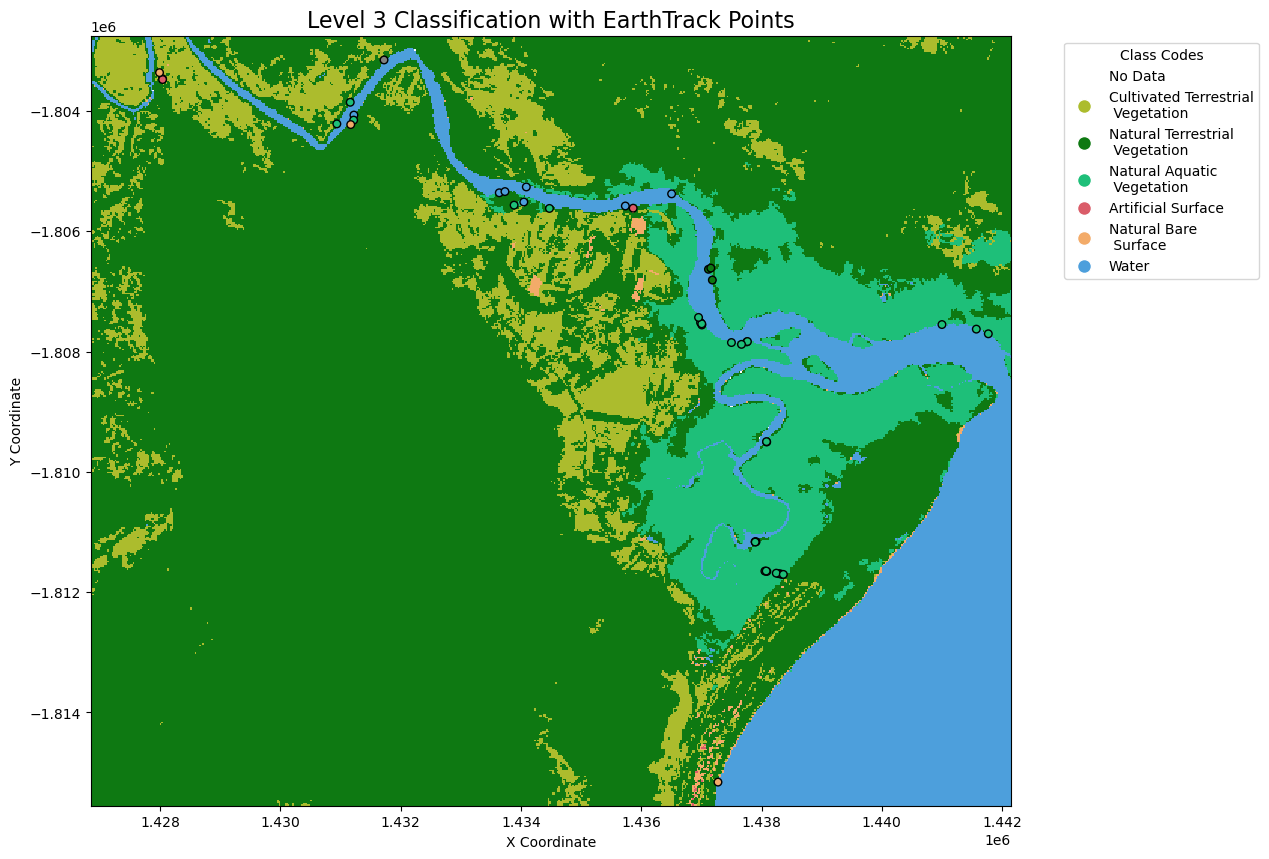

In [7]:
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from matplotlib.lines import Line2D
from matplotlib.colors import ListedColormap, BoundaryNorm
import numpy as np
from mycolourschemes import l3change_colors, l3change_labels
from landcover import lc_colours  
import matplotlib.colors as mcolours
from shapely.geometry import Point

def plot_level3_with_earthtrack():
    level3_data = lc.level3.isel(time=0)  # Adjust if needed
    
    class_codes = list(lc_colours['level3'].keys())
    
    color_list = [
        mcolours.to_rgba([x / 255.0 for x in lc_colours['level3'][code][:-1]])  
        for code in class_codes
    ]
    
    custom_cmap = ListedColormap(color_list)
    norm = BoundaryNorm(boundaries=class_codes + [max(class_codes) + 1], ncolors=len(color_list))
    
    fig, ax = plt.subplots(figsize=(12, 10))
    
    level3_data.plot(ax=ax, cmap=custom_cmap, norm=norm, add_colorbar=False)
    
    ax.set_title("Level 3 Classification with EarthTrack Points", fontsize=16)
    ax.set_xlabel("X Coordinate")
    ax.set_ylabel("Y Coordinate")
    
    points_gdf = geo_data  
    
    if points_gdf.crs is None:
        points_gdf.set_crs('EPSG:4326', inplace=True)  
    
    points_gdf = points_gdf.to_crs(level3_data.crs)  
    
    points_gdf['color'] = points_gdf['class_code'].map({
        code: lc_colours['level3'][code][:-1]  
        for code in class_codes
    })
    
    points_gdf['color'] = points_gdf['color'].apply(
        lambda col: mcolours.to_rgba([x / 255.0 for x in col]) if isinstance(col, tuple) else '#808080'  
    )
    
    points_gdf.plot(ax=ax, c=points_gdf['color'], markersize=30, edgecolor='black', label='EarthTrack Points')
    
    legend_handles = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor=mcolours.to_rgba([x / 255.0 for x in lc_colours['level3'][code][:-1]]),
               markersize=10, label=lc_colours['level3'][code][4])  # Assuming name is in 5th index
        for code in class_codes
    ]
    
    ax.legend(handles=legend_handles, title="Class Codes", bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.show()

plot_level3_with_earthtrack()

### Generate and export a confusion matrix
The confusion matrix [Congalton, 1991](https://www.sciencedirect.com/science/article/abs/pii/003442579190048B) is a table with rows that represent actual classes and columns are predicted classes.  Correct predictions are on the diagonal whilst the off-diagonal elements indicate misclassifications.

The illustration shows the number of reference points for each of the Level 3 categories that are correctly or incorrectly assigned.

(Note that CTV = Cultivated Terrestrial Vegetation, NTV = Natural Terrestrial Vegetation (woody or herbaceous), NAV = Natural Aquatic Vegetation (mainly mangroves), AS = Artificial Surface, BS = Bare Surface and W = Water).

             X          Y   l3 l3classifcode  l3_numeric
0   145.405193 -16.278066  124           NAV       124.0
1   145.405436 -16.278406  124           NAV       124.0
2   145.405400 -16.278232  124           NAV       124.0
3   145.417294 -16.310088  112           NAV       124.0
4   145.417150 -16.310094  220           NAV       124.0
5   145.417172 -16.310142  220           NAV       124.0
6   145.412629 -16.280232  124           NAV       124.0
7   145.412721 -16.280168  124           NAV       124.0
8   145.417316 -16.294942  124           NAV       124.0
9   145.417280 -16.294892  220           NAV       124.0
10  145.421827 -16.314574  124           NAV       124.0
11  145.421526 -16.314518  124           NAV       124.0
12  145.421232 -16.314517  124           NAV       124.0
13  145.420922 -16.314481  124           NAV       124.0
14  145.419435 -16.314374  124           NAV       124.0
15  145.419135 -16.314351  124           NAV       124.0
16  145.419331 -16.314318  124 

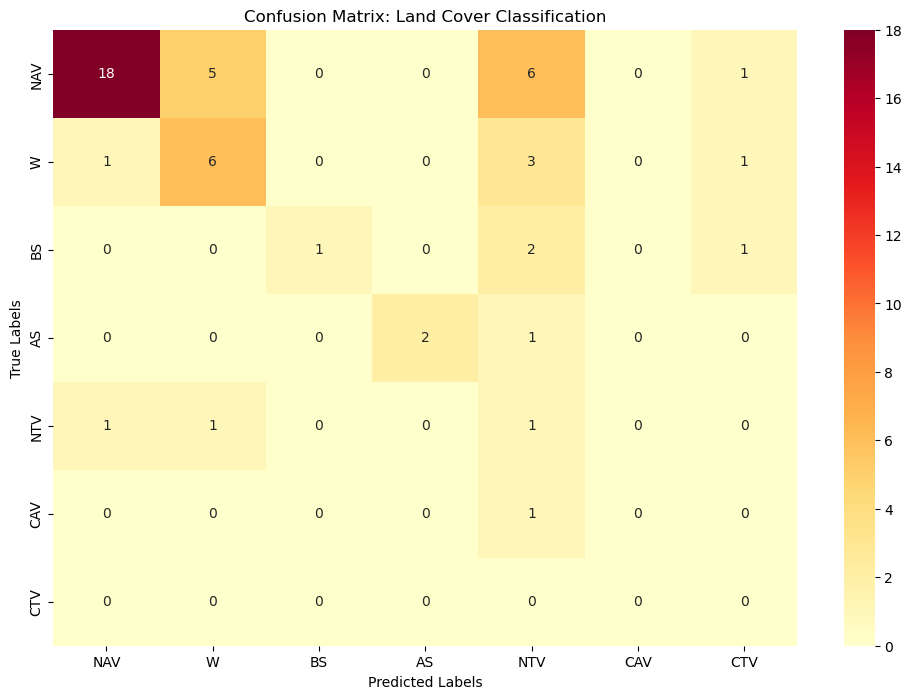

In [8]:
import pandas as pd
import numpy as np
import xarray as xr
from shapely.geometry import Point
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
from mycolourschemes import l3change_colors, l3change_labels
import seaborn as sns
df=data
class_codes=class_code_map
land_cover_classes = list(class_codes.values())
class_labels = list(class_codes.keys())

if 'X' not in df.columns or 'Y' not in df.columns or 'l3classifcode' not in df.columns:
    print("The CSV file must contain 'X' (longitude), 'Y' (latitude), and 'l3classifcode' columns.")
else:
    points = [Point(lon, lat) for lon, lat in zip(df['X'], df['Y'])]
    
    points_gdf = gpd.GeoDataFrame(df, geometry=points, crs="EPSG:4326")
    points_gdf = points_gdf.to_crs("EPSG:3577")
    
    def get_land_cover_class(row):
        lat, lon = row.geometry.y, row.geometry.x
        x_idx = np.abs(lc.level3.x - lon).argmin()  
        y_idx = np.abs(lc.level3.y - lat).argmin()  
        return lc.level3.isel(time=0).values[y_idx, x_idx]  
    
    points_gdf['l3'] = points_gdf.apply(get_land_cover_class, axis=1)
    
    def map_l3classifcode_to_numeric(classification):
        return class_codes.get(classification, np.nan) 
    
    points_gdf['l3_numeric'] = points_gdf['l3classifcode'].apply(map_l3classifcode_to_numeric)
    
    points_gdf = points_gdf.dropna(subset=['l3', 'l3_numeric'])

    print(points_gdf[['X', 'Y', 'l3', 'l3classifcode', 'l3_numeric']])

    y_pred = points_gdf['l3'].values
    y_true = points_gdf['l3_numeric'].values

    cm = confusion_matrix(y_true, y_pred, labels=land_cover_classes)

    accuracy = accuracy_score(y_true, y_pred)
    print(f"Accuracy: {accuracy * 100:.2f}%")

    row_sums = cm.sum(axis=1)
    col_sums = cm.sum(axis=0)

    class_accuracies = cm.diagonal() / row_sums
    user_accuracies = cm.diagonal() / col_sums

    cm_df = pd.DataFrame(cm, index=class_labels, columns=class_labels)
    cm_df['Total (Actual)'] = row_sums
    cm_df['Accuracy (%)'] = (class_accuracies * 100).round(2)
    cm_df['PA (%)'] = (class_accuracies * 100).round(2)
    cm_df['UA (%)'] = (user_accuracies * 100).round(2)
    cm_df.loc['Total (Predicted)', :] = np.append(col_sums, [None, None, None, None])

    cm_df.to_excel('./outputs/confusion_matrix_with_accuracy_pa_ua.xlsx', index=True)
    print("Confusion matrix with sums, accuracies, PA, and UA saved as 'confusion_matrix_with_accuracy_pa_ua.xlsx'.")

    overall_accuracy = accuracy_score(y_true, y_pred)
    print(f"Overall Accuracy: {overall_accuracy * 100:.2f}%")

    plt.figure(figsize=(12, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="YlOrRd", 
                xticklabels=class_labels, yticklabels=class_labels)
    plt.title('Confusion Matrix: Land Cover Classification')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()


### Accuracy metrics.
**User's Accuracy** defines the proportion of correctly classified pixels of a given class out of all pixels that were predicted to below to that class.

**Producer's Accuracy** refers to the proportion of correctly classified pixels of a given class out of all pixels that actually below to that class. 

**Overall Accuracy** is the proportion of all correctly classified pixels (for all classes) to the total number of pixels. 

The confusion matrix is exported to your outputs folder, where you can build on these initial calculations of error. 


## Tags
Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex.html)